---
title: "近地点マップを計算するノートブック" \
author: "Naoya Ozaki" \
date: "30 January 2023" \
output: "periapsis_map_simpler"

---

# 1. 近地点検出

In [1]:
using LinearAlgebra

# Definition of Equation of Motion of Planar CRTBP
function eom_pcrtbp!(dx, x, μ, t)
    # Preparation
    r1 = x[1:2] + [μ, 0.0]
    r2 = x[1:2] - [1.0 - μ, 0.0]
    a_cori = [2.0x[4], -2.0x[3]]
    a_cf = [x[1], x[2]]
    # dx/dt
    dx[1:2] = x[3:4]
    dx[3:4] = -(1.0 - μ) * r1 / (norm(r1)^3) - μ * r2 / (norm(r2)^3) + a_cori + a_cf
end

eom_pcrtbp! (generic function with 1 method)

In [9]:
using DifferentialEquations

μ = 0.01215058426994

function condition(x, t, integrator) # Event when event_f(u,t) == 0
    r1 = x[1:2] + [μ, 0.0]
    r2 = x[1:2] - [1.0 - μ, 0.0]
    return 1 #norm(r1) > 1.0e-3 && norm(r2) > 1.0e-3
end

affect!(integrator) = terminate!(integrator)

cb = ContinuousCallback(condition, affect!)

x0 = [0.8369304414031459, -4.265566441114701, -4.076205405804159, -0.43142925920758124]
tspan = (0.0, 3.0*pi)
prob = ODEProblem(eom_pcrtbp!, x0, tspan, μ)
sol = solve(prob, Vern7(), callback=cb, reltol=1e-10, abstol=1e-10)

retcode: Success
Interpolation: specialized 7th order lazy interpolation
t: 285-element Vector{Float64}:
 0.0
 0.01779763949430023
 0.06210963302223746
 0.12189859952670816
 0.1867692538764423
 0.2617555358388871
 0.3432199817059907
 0.43370988999868754
 0.5310575129467536
 0.6354355456232537
 ⋮
 8.491657720463234
 8.60616905040545
 8.722860775644682
 8.841846523630744
 8.963135271846586
 9.086083175337592
 9.209684323766881
 9.33286468216004
 9.42477796076938
u: 285-element Vector{Vector{Float64}}:
 [0.8369304414031459, -4.265566441114701, -4.076205405804159, -0.43142925920758124]
 [0.7643815024426781, -4.272621391903631, -4.076239092668735, -0.3613867635270568]
 [0.5838423988989129, -4.284781287190531, -4.071055174396137, -0.18760509056736102]
 [0.34093299907315255, -4.2890314021419265, -4.0522591963815096, 0.04502614094361081]
 [0.07912722542472302, -4.278008018689278, -4.016772383895408, 0.2941911993137691]
 [-0.21994685572515435, -4.24531263592278, -3.9566217373416657, 0.576758310

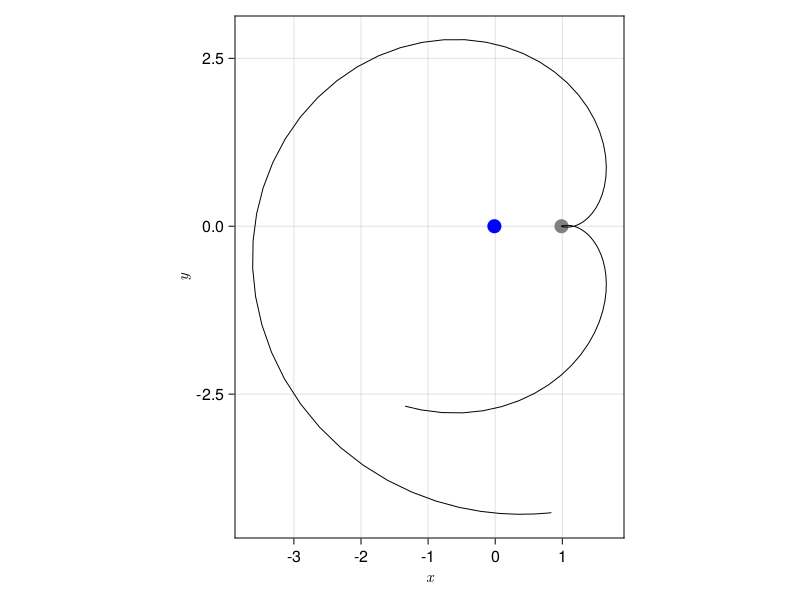

In [10]:
using CairoMakie
Makie.inline!(true)

fig = Figure()
ax = Axis(fig[1, 1]; xlabel=L"x", ylabel=L"y")
scatter!(-μ, 0.0; markersize=20, color=:blue)
scatter!(1.0 - μ, 0.0; markersize=20, color=:gray)
lines!(sol[1, :], sol[2, :]; linewidth=1, color=:black)
ax.aspect = DataAspect()
fig

In [58]:
using LinearAlgebra

# Definition of Equation of Motion of Planar CRTBP
function eom_pcrtbp!(dx, x, μ, t)
    # Preparation
    r1 = x[1:2] + [μ, 0.0]
    r2 = x[1:2] - [1.0 - μ, 0.0]
    a_cori = [2.0x[4], -2.0x[3]]
    a_cf = [x[1], x[2]]
    # dx/dt
    dx[1:2] = x[3:4]
    dx[3:4] = -(1.0 - μ) * r1 / (norm(r1)^3) - μ * r2 / (norm(r2)^3) + a_cori + a_cf
end

eom_pcrtbp! (generic function with 1 method)

In [59]:
using DifferentialEquations

# イベント処理#1: 半径方向速度から近地点を検知
function condition(x, t, integrator) # Event when event_f(u,t) == 0
    r1_vec = x[1:2] + [μ, 0.0]
    return r1_vec ⋅ x[3:4] # 半径方向速度（＝地球からみた探査機の位置ベクトルと速度ベクトルの内積）
end
affect!(integrator) = nothing # 保存をするだけなので，何も実行しない

# イベント処理#2: 地球 or 月に近づきすぎると計算を終了する（今回の例では使わないが，モンテカルロシミュレーションを解く際には有用）
function condition2(x, t, integrator) # Event when event_f(u,t) == 0
    r1 = x[1:2] + [μ, 0.0]
    r2 = x[1:2] - [1.0 - μ, 0.0]
    return norm(r1) > 1.0e-3 && norm(r2) > 1.0e-3
end
affect2!(integrator) = terminate!(integrator) # DifferentialEquations.jlが用意しているODEの計算停止関数

# イベント処理のインタフェース定義
cb = ContinuousCallback(condition, affect!, nothing, save_positions=(true, false))
cb2 = ContinuousCallback(condition2, affect2!, save_positions=(false, false))
cbs = CallbackSet(cb, cb2)

# 計算条件の設定
μ = 0.01215058426994 # 地球・月系のμ
x0 = [1.1000137986067107, 0.0, 0.41017439921470306, -0.2165455493337665]
tspan = (0.0, 20.0 * pi)

# 計算の実行
prob = ODEProblem(eom_pcrtbp!, x0, tspan, μ)
sol = solve(prob, Vern7(), callback=cbs, reltol=1e-10, abstol=1e-10, saveat=[0.0, 20.0 * pi])

# 近地点の位置・速度は以下の値を参照すれば良い
sol[:, 2:end-1]

4×10 Matrix{Float64}:
 -0.151908   -0.707854  -0.624618  …   0.0761133   0.795214   -0.742221
 -0.971019   -0.540734  -0.540212     -0.555731   -0.496088    0.664117
  0.0889165   0.150336   0.233572      0.91906     0.0768681  -0.0916683
 -0.0139103  -0.196799  -0.270066      0.125875    0.123217   -0.102449

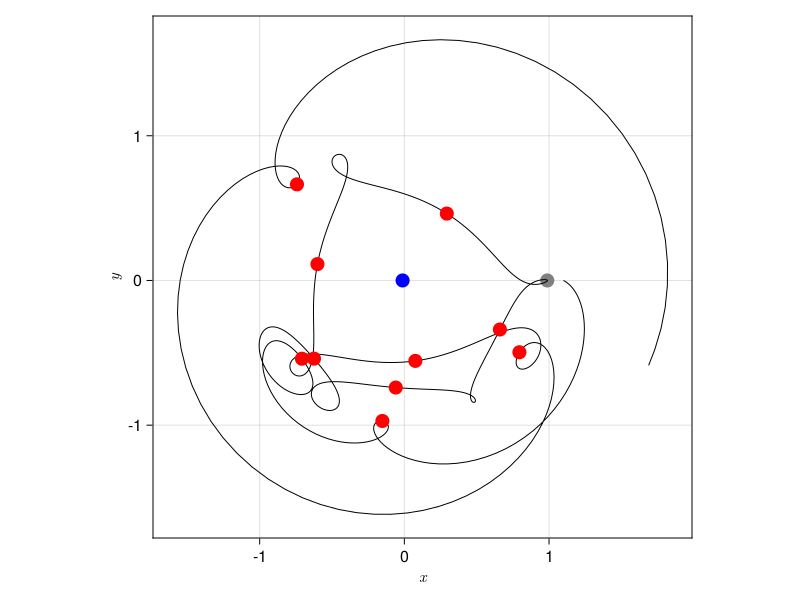

In [60]:
using CairoMakie
Makie.inline!(true)

sol_forplot = solve(prob, Vern7(), callback=cbs, reltol=1e-10, abstol=1e-10)

fig = Figure()
ax = Axis(fig[1, 1]; xlabel=L"x", ylabel=L"y")
scatter!(-μ, 0.0; markersize=20, color=:blue)
scatter!(1.0 - μ, 0.0; markersize=20, color=:gray)
lines!(sol_forplot[1, :], sol_forplot[2, :]; linewidth=1, color=:black)
scatter!(sol[1, 2:end-1], sol[2, 2:end-1]; markersize=20, color=:red)
ax.aspect = DataAspect()
fig

# 2. 近地点マップ

In [2]:
# 並列計算の初期化
using Distributed
addprocs(exeflags="--project=$(Base.active_project())")
@everywhere using DifferentialEquations
@everywhere using LinearAlgebra

In [23]:
# 問題設定の定義
num_trj = 2000
@everywhere μ = 0.01215058426994 # 地球・月系のμ
@everywhere t_fin = 2.0pi * 50
x0_temp = [0.8369304414031459, -4.265566441114701, -4.076205405804159, -0.43142925920758124]
tspan = (0.0, t_fin)

# 平面円制限三体問題の運動方程式の定義
@everywhere function eom_pcrtbp!(dx, x, μ, t)
    # Preparation
    r1 = x[1:2] + [μ, 0.0]
    r2 = x[1:2] - [1.0 - μ, 0.0]
    a_cori = [2.0x[4], -2.0x[3]]
    a_cf = [x[1], x[2]]
    # dx/dt
    dx[1:2] = x[3:4]
    dx[3:4] = -(1.0 - μ) * r1 / (norm(r1)^3) - μ * r2 / (norm(r2)^3) + a_cori + a_cf
end

# イベント処理#1: 半径方向速度から近地点を検知
@everywhere function condition(x, t, integrator) # Event when event_f(u,t) == 0
    r1_vec = x[1:2] + [μ, 0.0]
    return r1_vec ⋅ x[3:4] # 半径方向速度（＝地球からみた探査機の位置ベクトルと速度ベクトルの内積）
end
@everywhere affect!(integrator) = nothing # 保存をするだけなので，何も実行しない

# イベント処理#2: 地球 or 月に近づきすぎると計算を終了する（今回の例では使わないが，モンテカルロシミュレーションを解く際には有用）
@everywhere function condition2(x, t, integrator) # Event when event_f(u,t) == 0
    r1 = x[1:2] + [μ, 0.0]
    r2 = x[1:2] - [1.0 - μ, 0.0]
    return norm(r1) > 1.0e-3 && norm(r2) > 1.0e-3
end
@everywhere affect2!(integrator) = terminate!(integrator) # DifferentialEquations.jlが用意しているODEの計算停止関数

# イベント処理のインタフェース定義
cb = ContinuousCallback(condition, affect!, nothing, save_positions=(true, false))
cb2 = ContinuousCallback(condition2, affect2!, save_positions=(false, false))
cbs = CallbackSet(cb, cb2)

# 試行ごとに実行したい処理の定義
@everywhere function prob_func(prob, i, repeat)
    jacobi_constant = 3.15 # ヤコビ定数
    x0 = 3.0rand() # 初期位置のx成分を0〜3までの範囲でランダムに定義
    φ0 = 2.0pi*rand()
    v0 = sqrt(x0^2 + 2.0 * (1.0 - μ) / abs(x0 + μ) + 2.0 * μ / abs(x0 - 1.0 + μ) - jacobi_constant) # ヤコビ定数が一致するように速度を定義
    u0 = [x0, 0.0, v0 * cos(φ0), v0 * sin(φ0)]
    remake(prob, u0=u0) # 初期値を試行ごとにランダムに変更
end

# アンサンブルシミュレーションを定義し，問題を解く
prob = ODEProblem(eom_pcrtbp!, x0_temp, tspan, μ)
ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
sim = solve(ensemble_prob, Vern7(), EnsembleDistributed(), trajectories=num_trj, callback=cbs, saveat=t_fin);

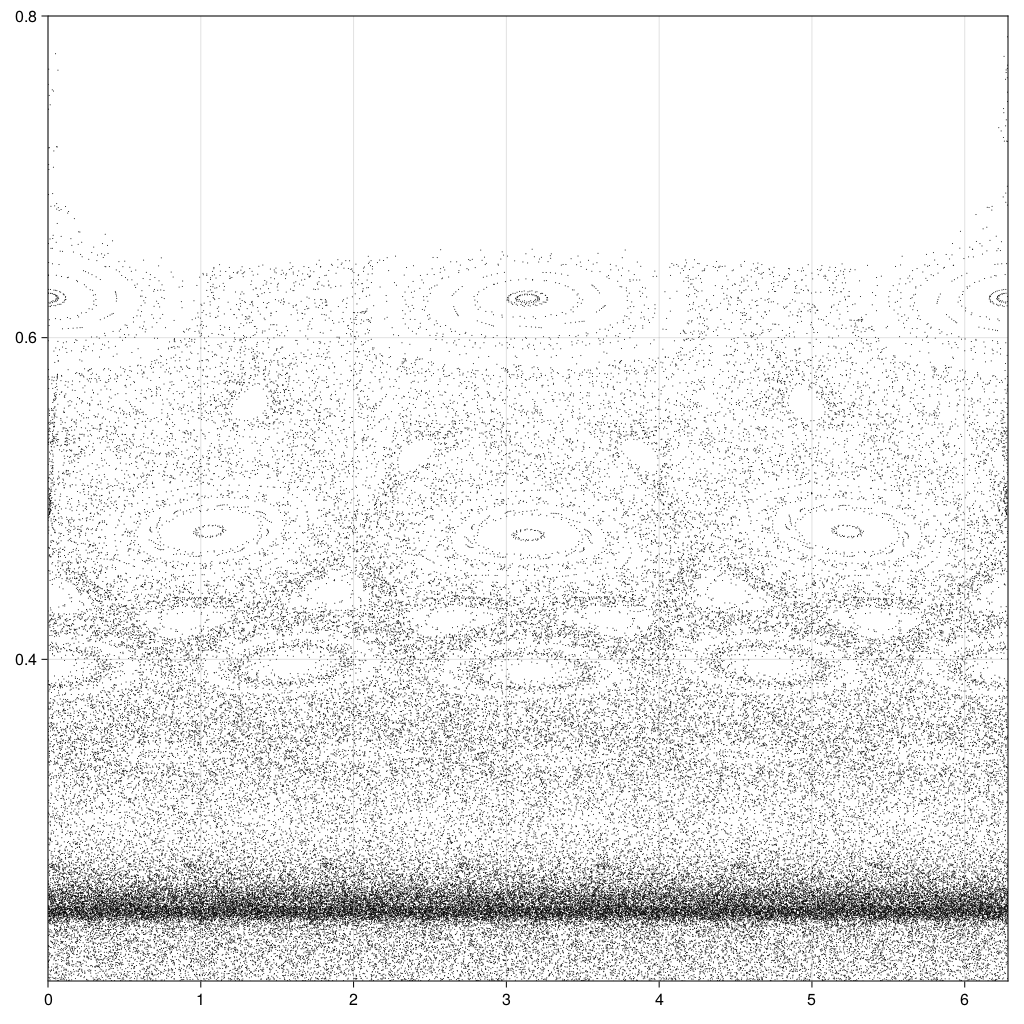

In [24]:
# Makieによる結果の描画
using CairoMakie

fig = Figure(; resolution=(1024, 1024))
ax = Axis(fig[1, 1])

for n = 1:num_trj
    x_all = hcat(sim[n].u...)'
    x_all = x_all[2:end-1, :] # 初期値と終端値を取り除く

    # θと軌道長半径の計算
    θ = atan.(x_all[:, 2], x_all[:, 1] .+ μ)
    r_1 = sqrt.((x_all[:, 1] .+ μ) .^ 2 + x_all[:, 2] .^ 2)
    v_1_sq = (x_all[:, 3] - x_all[:, 2]) .^ 2 + (x_all[:, 4] + x_all[:, 1] .+ μ) .^ 2
    a = 1.0 ./ (2.0 ./ r_1 - v_1_sq ./ (1.0 - μ))

    scatter!(mod2pi.(θ), a, color=:black, markersize=1.5)
end

xlims!(0.0, 2.0pi)
ylims!(0.2, 0.8)
fig